# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM stroma

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8763
CD56 bright NK         449
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1464
tDC                    193
tip EC                 362
Length: 64, dtype: int64

In [6]:
adata = adata[adata.obs['cell.labels'].isin(['adipo-CAR', 'arteriolar fibroblast', 'tip EC', 'stromal macrophage', 
              'sinusoidal EC', 'schwann cells', 'proliferating EC', 'osteoclast', 'osteochondral precursor', 
              'osteoblast precursor', 'osteoblast', 'myofibroblast', 'muscle stem cell', 'muscle', 
              'monocytoid macrophage', 'erythroid macrophage', 'immature EC', 'endosteal fibroblast', 
              'early osteoblast', 'chondrocyte'])].copy()

In [7]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
adipo-CAR                   353
arteriolar fibroblast        83
chondrocyte                  80
early osteoblast            280
endosteal fibroblast         54
erythroid macrophage         92
immature EC                  42
monocytoid macrophage       290
muscle                      131
muscle stem cell            254
myofibroblast                78
osteoblast                  363
osteoblast precursor        456
osteochondral precursor     191
osteoclast                 1221
proliferating EC             26
schwann cells                 9
sinusoidal EC               550
stromal macrophage         1464
tip EC                      362
dtype: int64

In [8]:
adata.obs["cell.labels_broad"] = adata.obs["cell.labels"]
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["muscle stem cell"], ["muscle"])

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
adipo-CAR                   353
arteriolar fibroblast        83
chondrocyte                  80
early osteoblast            280
endosteal fibroblast         54
erythroid macrophage         92
immature EC                  42
monocytoid macrophage       290
muscle                      385
myofibroblast                78
osteoblast                  363
osteoblast precursor        456
osteochondral precursor     191
osteoclast                 1221
proliferating EC             26
schwann cells                 9
sinusoidal EC               550
stromal macrophage         1464
tip EC                      362
dtype: int64

In [10]:
# order tissue_cell.labels column

adata.obs["cell.labels"] = adata.obs["cell.labels"].astype("category")

final_order = ['stromal macrophage',
'monocytoid macrophage',
'erythroid macrophage',
'osteoclast',
'immature EC',
'sinusoidal EC',
'proliferating EC',
'tip EC',
'endosteal fibroblast',
'arteriolar fibroblast',
'myofibroblast',
'muscle',
'schwann cells',
'osteochondral precursor',
'adipo-CAR',
'osteoblast precursor',
'early osteoblast',
'osteoblast',
'chondrocyte']

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(final_order)

In [11]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
stromal macrophage         1464
monocytoid macrophage       290
erythroid macrophage         92
osteoclast                 1221
immature EC                  42
sinusoidal EC               550
proliferating EC             26
tip EC                      362
endosteal fibroblast         54
arteriolar fibroblast        83
myofibroblast                78
muscle                      385
schwann cells                 9
osteochondral precursor     191
adipo-CAR                   353
osteoblast precursor        456
early osteoblast            280
osteoblast                  363
chondrocyte                  80
dtype: int64

# Pre-process the human stroma dataset

In [12]:
# normalise count data 
sc.pp.normalize_total(adata)

In [13]:
# log the count data 
sc.pp.log1p(adata)

In [14]:
adata

AnnData object with n_obs × n_vars = 6379 × 33712 
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold', 'cell.labels_broad'
    var: 'gene_ids-1', 'feature_types-1'
    obsm: 'X_orig_pca', 'X_pca', 'X_umap'

In [15]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [16]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [17]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [18]:
scrna_data = adata

# Run DEGs for the equivalent Baccin mouse stroma cells and select top 100 genes

In [19]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/baccin_mouse/data/mouse_data_raw_20200422.h5ad')

In [20]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Adipo-CAR             528
Arteriolar ECs         97
Arteriolar fibro.     376
B cell                 80
Chondrocytes           34
Dendritic cells        61
Endosteal fibro.      434
Eo/Baso prog.         337
Ery prog.             227
Ery/Mk prog.          598
Erythroblasts        1197
Fibro/Chondro p.       69
Gran/Mono prog.      1157
LMPPs                1316
Mk prog.              358
Mono prog.            520
Monocytes             210
Myofibroblasts        439
NK cells               82
Neutro prog.          407
Neutrophils           261
Ng2+ MSCs             124
Osteo-CAR              57
Osteoblasts            53
Schwann cells          89
Sinusoidal ECs        109
Smooth muscle          22
Stromal fibro.        109
T cells               136
large pre-B.          135
pro-B                 291
small pre-B.          183
dtype: int64

In [21]:
adata = adata[adata.obs['cell.labels'].isin(["Arteriolar ECs", "Sinusoidal ECs", "Schwann cells", "Adipo-CAR", 
                                             "Osteo-CAR", "Osteoblasts", "Chondrocytes", "Fibro/Chondro p.", 
                                             "Arteriolar fibro.", "Endosteal fibro.", "Smooth muscle", 
                                             "Myofibroblasts", "Ng2+ MSCs", "Stromal fibro."])].copy()

In [22]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Adipo-CAR            528
Arteriolar ECs        97
Arteriolar fibro.    376
Chondrocytes          34
Endosteal fibro.     434
Fibro/Chondro p.      69
Myofibroblasts       439
Ng2+ MSCs            124
Osteo-CAR             57
Osteoblasts           53
Schwann cells         89
Sinusoidal ECs       109
Smooth muscle         22
Stromal fibro.       109
dtype: int64

In [23]:
# order tissue_cell.labels column

adata.obs["cell.labels"] = adata.obs["cell.labels"].astype("category")

adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories([
'Sinusoidal ECs',
'Arteriolar ECs', 
'Endosteal fibro.',
'Arteriolar fibro.',
'Myofibroblasts',
'Stromal fibro.',
'Smooth muscle',
'Schwann cells',
'Ng2+ MSCs',
'Adipo-CAR',
'Osteo-CAR',
'Osteoblasts', 
'Fibro/Chondro p.',
'Chondrocytes'])

cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Sinusoidal ECs       109
Arteriolar ECs        97
Endosteal fibro.     434
Arteriolar fibro.    376
Myofibroblasts       439
Stromal fibro.       109
Smooth muscle         22
Schwann cells         89
Ng2+ MSCs            124
Adipo-CAR            528
Osteo-CAR             57
Osteoblasts           53
Fibro/Chondro p.      69
Chondrocytes          34
dtype: int64

In [24]:
# normalise count data 
sc.pp.normalize_total(adata)

In [25]:
# log the count data 
sc.pp.log1p(adata)

In [26]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [27]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [28]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [29]:
# run degs on normalised and logged data (saved as adata.raw), not on additionally scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels', method='wilcoxon', use_raw=False, log_transformed=True, n_genes=1000)

In [30]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change=0.25, use_raw=False)

In [31]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_20210126.csv")
degs_by_cluster[:10]

,Sinusoidal ECs_n,Sinusoidal ECs_l,Arteriolar ECs_n,Arteriolar ECs_l,Endosteal fibro._n,Endosteal fibro._l,Arteriolar fibro._n,Arteriolar fibro._l,Myofibroblasts_n,Myofibroblasts_l,...,Adipo-CAR_n,Adipo-CAR_l,Osteo-CAR_n,Osteo-CAR_l,Osteoblasts_n,Osteoblasts_l,Fibro/Chondro p._n,Fibro/Chondro p._l,Chondrocytes_n,Chondrocytes_l
0,Plvap,9.777742,Tm4sf1,5.844638,Pi16,4.876131,Serpinf1,3.232969,Rpl18a,3.859416,...,Cxcl12,6.117310,Tnc,5.628873,Col1a1,5.439332,Comp,5.210753,Col9a3,13.792507
1,Sepp1,3.778103,Ly6e,5.235610,Mfap5,4.092308,Dcn,2.611412,Rps5,3.893073,...,Hp,7.998065,Wif1,6.851064,Col1a2,5.172942,Lgals3,4.147619,Col9a2,13.917876
2,Gng11,4.239138,Slc9a3r2,7.828618,S100a6,2.825019,Col3a1,3.138335,Rps6,3.855688,...,Tmem176b,4.902675,Kcnk2,8.486124,Ifitm5,11.087225,Mfge8,3.898006,Lect1,14.413549
3,Cldn5,6.803056,Ly6c1,3.499561,Ly6a,3.515509,Pcolce,2.519043,Rps19,3.904289,...,Lpl,6.970576,Alpl,5.983037,Sparc,3.671983,Tsc22d1,3.024973,Col9a1,14.772593
4,Egfl7,6.886823,Egfl7,6.804814,Clec3b,3.806894,Nbl1,2.721031,Rpl13,3.653038,...,Tmem176a,4.494699,Igfbp4,2.889747,Serpinh1,2.993809,Fmod,7.193307,Hapln1,12.695127
5,Lrg1,8.804356,Esam,7.211186,Cd34,3.339982,Gsn,2.448025,Rps14,3.534955,...,Adipoq,7.931683,Olfml3,3.769314,Cadm1,7.727442,Fxyd5,3.245221,Col11a1,9.666176
6,Tcn2,5.311046,Cav1,5.705824,Ly6c1,3.344826,Gas1,2.992189,Rps4x,3.491280,...,H2-D1,3.830194,B2m,2.632725,Cgref1,9.770432,Chad,7.502733,Mia,13.899599
7,Ly6e,3.532060,Sox17,10.411519,Fstl1,2.859972,Col1a1,2.233126,Rps18,3.540536,...,Apoe,3.918617,Rgs3,4.388453,Car3,10.070471,Cd9,2.385819,3110079O15Rik,13.993590
8,Cdh5,7.372761,Fabp4,6.668997,Igfbp6,3.289869,Col1a2,1.836366,Rpl37,3.554471,...,Esm1,6.159978,Cd63,2.509048,Fkbp11,7.367804,Rgcc,3.033925,Col2a1,15.796575
9,Esam,6.243892,Pecam1,5.178740,Timp2,2.904427,Igfbp6,2.445596,Rplp0,3.491497,...,Gas6,4.083918,Limch1,6.777151,Cpe,5.243202,Sparc,2.207354,Sparc,3.409082


In [32]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_filtered_20210126.csv")
degs_by_cluster_filtered[:10]

,Sinusoidal ECs_n,Sinusoidal ECs_l,Arteriolar ECs_n,Arteriolar ECs_l,Endosteal fibro._n,Endosteal fibro._l,Arteriolar fibro._n,Arteriolar fibro._l,Myofibroblasts_n,Myofibroblasts_l,...,Adipo-CAR_n,Adipo-CAR_l,Osteo-CAR_n,Osteo-CAR_l,Osteoblasts_n,Osteoblasts_l,Fibro/Chondro p._n,Fibro/Chondro p._l,Chondrocytes_n,Chondrocytes_l
0,Plvap,9.777742,Tm4sf1,5.844638,Pi16,4.876131,Serpinf1,3.232969,Rpl18a,3.859416,...,Cxcl12,6.117310,Tnc,5.628873,Col1a1,5.439332,Comp,5.210753,Col9a3,13.792507
1,Sepp1,3.778103,Ly6e,5.235610,Mfap5,4.092308,Dcn,2.611412,Rps5,3.893073,...,Hp,7.998065,Wif1,6.851064,NaN,5.172942,Lgals3,4.147619,Col9a2,13.917876
2,Gng11,4.239138,Slc9a3r2,7.828618,S100a6,2.825019,Col3a1,3.138335,Rps6,3.855688,...,Tmem176b,4.902675,Kcnk2,8.486124,Ifitm5,11.087225,Mfge8,3.898006,Lect1,14.413549
3,Cldn5,6.803056,Ly6c1,3.499561,Ly6a,3.515509,Pcolce,2.519043,Rps19,3.904289,...,Lpl,6.970576,Alpl,5.983037,NaN,3.671983,Tsc22d1,3.024973,Col9a1,14.772593
4,Egfl7,6.886823,Egfl7,6.804814,Clec3b,3.806894,Nbl1,2.721031,Rpl13,3.653038,...,Tmem176a,4.494699,Igfbp4,2.889747,NaN,2.993809,Fmod,7.193307,Hapln1,12.695127
5,Lrg1,8.804356,Esam,7.211186,Cd34,3.339982,Gsn,2.448025,Rps14,3.534955,...,Adipoq,7.931683,Olfml3,3.769314,Cadm1,7.727442,Fxyd5,3.245221,Col11a1,9.666176
6,Tcn2,5.311046,Cav1,5.705824,Ly6c1,3.344826,Gas1,2.992189,Rps4x,3.491280,...,H2-D1,3.830194,B2m,2.632725,Cgref1,9.770432,Chad,7.502733,Mia,13.899599
7,Ly6e,3.532060,Sox17,10.411519,Fstl1,2.859972,Col1a1,2.233126,Rps18,3.540536,...,Apoe,3.918617,Rgs3,4.388453,Car3,10.070471,NaN,2.385819,3110079O15Rik,13.993590
8,Cdh5,7.372761,Fabp4,6.668997,Igfbp6,3.289869,Col1a2,1.836366,Rpl37,3.554471,...,Esm1,6.159978,NaN,2.509048,Fkbp11,7.367804,Rgcc,3.033925,Col2a1,15.796575
9,Esam,6.243892,Pecam1,5.178740,Timp2,2.904427,Igfbp6,2.445596,Rplp0,3.491497,...,Gas6,4.083918,Limch1,6.777151,Cpe,5.243202,NaN,2.207354,NaN,3.409082


In [33]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Sinusoidal ECs       109
Arteriolar ECs        97
Endosteal fibro.     434
Arteriolar fibro.    376
Myofibroblasts       439
Stromal fibro.       109
Smooth muscle         22
Schwann cells         89
Ng2+ MSCs            124
Adipo-CAR            528
Osteo-CAR             57
Osteoblasts           53
Fibro/Chondro p.      69
Chondrocytes          34
dtype: int64

# Convert DEG list to human genes in R/py

In [34]:
# convert anndata to sce
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [35]:
%R d = as.data.frame( R.Version() )
%R d = d['version.string']

,version.string
1,R version 3.6.2 (2019-12-12)


In [36]:
%%R 

library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [37]:
%%R 

# create a key to map the mouse DEGs to human DEGs (in R, usng biomart)

# Load the filtered DEGs in
mouse_degs_filtered <- read.csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_filtered_20210126.csv")
mouse_degs_filtered

# load the biomart needed for conversion
require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# make df = all columns ending with _n (i.e., cols with mouse gene names in)
df = mouse_degs_filtered[, -grep("_l", colnames(mouse_degs_filtered))]
# remove index column
df <- subset(df, select = -c(X))
df
colnames(df)

# run a loop to save a df of the MGI.symbol (mouse genes) and corresponding (human genes) for each celltype DEG col
final_gene_key = list()
for (i in colnames(df)){
  # print the celltype column we are looking at degs for
  print(i)
  # save gene key for conversion of these genes as a df
  column_gene_key = getLDS(attributes = c("mgi_symbol"), filters = "external_gene_name", values = df[[i]], 
                           mart = mouse, attributesL = c("external_gene_name"), martL = human, uniqueRows=T)
  print(head(column_gene_key))
  print('printing size of this celltypes DEGs')
  print(nrow(column_gene_key))
  print('printing size of combined celltype DEGs')
  final_gene_key = rbind(column_gene_key, final_gene_key)
  print(nrow(final_gene_key))
}

# save the conversion mouse to human key for input into python
write.csv(final_gene_key, "/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_filtered_species_gene_key_20210126.csv")

R[write to console]: Loading required package: biomaRt



[1] "Sinusoidal.ECs_n"
  MGI.symbol Gene.name
1       Xbp1      XBP1
2       Tgm2      TGM2
3       Lipg      LIPG
4     Ube2g2    UBE2G2
5       Tcf4      TCF4
6     Snrpb2    SNRPB2
[1] "printing size of this celltypes DEGs"
[1] 472
[1] "printing size of combined celltype DEGs"
[1] 472
[1] "Arteriolar.ECs_n"
  MGI.symbol Gene.name
1        Id1       ID1
2       Cst3      CST3
3       Flt1      FLT1
4     Ralbp1    RALBP1
5     Myl12b    MYL12B
6    Tsc22d1   TSC22D1
[1] "printing size of this celltypes DEGs"
[1] 443
[1] "printing size of combined celltype DEGs"
[1] 915
[1] "Endosteal.fibro._n"
  MGI.symbol  Gene.name
1     Mrpl23 AC004556.3
2      Procr      PROCR
3      Romo1      ROMO1
4     Triobp     TRIOBP
5    Emilin2    EMILIN2
6     Ranbp1     RANBP1
[1] "printing size of this celltypes DEGs"
[1] 688
[1] "printing size of combined celltype DEGs"
[1] 1603
[1] "Arteriolar.fibro._n"
  MGI.symbol Gene.name
1    mt-Nd4l   MT-ND4L
2     mt-Nd3    MT-ND3
3     Ergic3    ERGIC3
4    

# Save top 100 filtered DEGs within dictionary

In [38]:
# sort the degs_by_cluster_filtered df genes by logfc
degs_by_cluster_filtered = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_filtered_20210126.csv")
df = degs_by_cluster_filtered
df[:5]

,Unnamed: 0,Sinusoidal ECs_n,Sinusoidal ECs_l,Arteriolar ECs_n,Arteriolar ECs_l,Endosteal fibro._n,Endosteal fibro._l,Arteriolar fibro._n,Arteriolar fibro._l,Myofibroblasts_n,...,Adipo-CAR_n,Adipo-CAR_l,Osteo-CAR_n,Osteo-CAR_l,Osteoblasts_n,Osteoblasts_l,Fibro/Chondro p._n,Fibro/Chondro p._l,Chondrocytes_n,Chondrocytes_l
0,0,Plvap,9.777742,Tm4sf1,5.844638,Pi16,4.876131,Serpinf1,3.232969,Rpl18a,...,Cxcl12,6.117310,Tnc,5.628873,Col1a1,5.439332,Comp,5.210753,Col9a3,13.792507
1,1,Sepp1,3.778103,Ly6e,5.235610,Mfap5,4.092308,Dcn,2.611412,Rps5,...,Hp,7.998066,Wif1,6.851064,NaN,5.172942,Lgals3,4.147619,Col9a2,13.917876
2,2,Gng11,4.239138,Slc9a3r2,7.828618,S100a6,2.825019,Col3a1,3.138335,Rps6,...,Tmem176b,4.902675,Kcnk2,8.486124,Ifitm5,11.087225,Mfge8,3.898006,Lect1,14.413549
3,3,Cldn5,6.803056,Ly6c1,3.499561,Ly6a,3.515509,Pcolce,2.519043,Rps19,...,Lpl,6.970576,Alpl,5.983038,NaN,3.671983,Tsc22d1,3.024973,Col9a1,14.772593
4,4,Egfl7,6.886823,Egfl7,6.804814,Clec3b,3.806894,Nbl1,2.721031,Rpl13,...,Tmem176a,4.494699,Igfbp4,2.889747,NaN,2.993809,Fmod,7.193307,Hapln1,12.695127


In [39]:
# use the species conversion key to replace genes in DEGs csv and filter for top 100 by logfc
# 1 - for each celltype, sort DEGs by logfc
# 2 - convert mouse genes to human genes (else, turn to nan)
# 3 - remove nans
# select top 100

gene_key = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_stroma_degs_filtered_species_gene_key_20210126.csv")
mouse_gene_list = gene_key["MGI.symbol"].tolist()
human_gene_list = gene_key["Gene.name"].tolist()
my_dict = {}

for i in adata.obs["cell.labels"].cat.categories:
    # for each DEG list:
    print(i)
    # assign cols
    gene_name = str(i) + "_n"
    logfc = str(i) + "_l"
    
    # sort values of genes based on logfc
    df = df.sort_values([logfc], ascending=False)
    gene_list = df[gene_name]
    # convert mouse genes to human genes
    gene_list = gene_list.replace(mouse_gene_list, human_gene_list)
    # if any mouse genes left over, convert to NAN
    gene_list = gene_list.replace(mouse_gene_list, 'nan')
    # remove nan values from genes
    cleanedList = [x for x in gene_list if str(x) != 'nan']
    #get top 100 genes
    top_100_genes = cleanedList[:100] 
    # save 100 degs as values in key named "celltype"_degs
    x = str(i) + "_degs"
    my_dict[x] = top_100_genes
    
# save df of top 100 humanised DEGs for mouse celltypes
final_mouse_degs = pd.DataFrame.from_dict(my_dict)
final_mouse_degs.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/mouse_humanised_top_100_degs_20210126.csv")
final_mouse_degs[:5]

Sinusoidal ECs
Arteriolar ECs
Endosteal fibro.
Arteriolar fibro.
Myofibroblasts
Stromal fibro.
Smooth muscle
Schwann cells
Ng2+ MSCs
Adipo-CAR
Osteo-CAR
Osteoblasts
Fibro/Chondro p.
Chondrocytes


,Sinusoidal ECs_degs,Arteriolar ECs_degs,Endosteal fibro._degs,Arteriolar fibro._degs,Myofibroblasts_degs,Stromal fibro._degs,Smooth muscle_degs,Schwann cells_degs,Ng2+ MSCs_degs,Adipo-CAR_degs,Osteo-CAR_degs,Osteoblasts_degs,Fibro/Chondro p._degs,Chondrocytes_degs
0,GPR182,PTPRR,LYPD2,MFAP4,FGFR4,ANGPTL7,OR51E1,MAP6D1,SPP1,HPR,ANGPT4,IFITM5,CILP2,Serpina1e
1,FAM167B,SOX17,WNT2,FBLN7,CHRNA1,CCL11,Map3k7cl,ST18,DMP1,ADIPOQ,KCNK2,BGLAP,CHAD,COL2A1
2,DNASE1L3,SEMA3G,SEMA3C,CPXM2,CHRDL2,CRISPLD2,MYH11,DSCAML1,MMP13,IL1RN,WIF1,BGLAP,FMOD,MATN3
3,STAB2,C1QTNF9,CD248,CILP,PAX7,COL15A1,CASQ2,OLIG2,VDR,LPL,LIMCH1,CPZ,NDUFA4L2,COL9A1
4,MRC1,GJA4,ISLR2,ITGBL1,CHODL,APOD,PLN,Haglr,SLIT2,KNG1,SLC36A2,BGLAP,Mfi2,Lect1


In [40]:
my_dict

{'Sinusoidal ECs_degs': ['GPR182',
  'FAM167B',
  'DNASE1L3',
  'STAB2',
  'MRC1',
  'PLVAP',
  'SELP',
  'STAB1',
  'CYP4B1',
  'Ctla2a',
  'APLNR',
  'LIPG',
  'UBD',
  'GPIHBP1',
  'KDR',
  'LRG1',
  'GPM6A',
  'BTNL9',
  'LTC4S',
  'FLT4',
  'CD300LG',
  'Clca3a1',
  'IPO11',
  'ROBO4',
  'EMCN',
  'KCNJ8',
  'USHBP1',
  'CDH5',
  'CMTM8',
  'GIMAP6',
  'GIMAP4',
  'EGFL7',
  'CLDN5',
  'TP53I11',
  'MMRN2',
  'RASIP1',
  'KANK3',
  'FABP4',
  'TIE1',
  'ADGRL4',
  'CD38',
  'FLT1',
  'APOLD1',
  'ESAM',
  'ACKR1',
  'SOX18',
  'ABCC9',
  'CD93',
  'UPP1',
  'ECSCR',
  'TRIM37',
  'F11R',
  'MYCT1',
  'TFPI',
  'Pvrl2',
  'PDE2A',
  'TCN2',
  'CRACR2B',
  'PTPRB',
  'LDB2',
  'FCER1G',
  'TMEM88',
  'TMEM204',
  'MCAM',
  'SMAGP',
  'ICAM2',
  'CYYR1',
  'C4orf48',
  'ENG',
  'ADGRG1',
  'ETS1',
  'STOM',
  'SCARB1',
  'SLCO2A1',
  'CLEC14A',
  'GALNT18',
  'CD36',
  'GNG11',
  'BOK',
  'TEK',
  'PLPP1',
  'GNGT2',
  'ELK3',
  'AQP1',
  'SH3BP5',
  'NRARP',
  'TM6SF1',
  'SRGN',
  

# Run cell cycle score comparisons

In [41]:
adata = scrna_data

In [42]:
# run through DEG list for each cell type, run score_genes function on adata object for these genes and save in .obs
celltypes_string_list = list(my_dict.keys())

DEG_lists=my_dict.values()
counter=0

for i in DEG_lists:
    sc.tl.score_genes(adata, gene_list=i, score_name=celltypes_string_list[counter])
    counter=counter+1

In [43]:
# save cell cycle scores within metadata as a dataframe (called enrichement scores)
adata.obs["labels"] = adata.obs["cell.labels"]
meta = pd.DataFrame(adata.obs)
enrichment_scores_df = meta[meta.columns[-17:]]
enrichment_scores_df

,mito.threshold,cell.labels_broad,Sinusoidal ECs_degs,Arteriolar ECs_degs,Endosteal fibro._degs,Arteriolar fibro._degs,Myofibroblasts_degs,Stromal fibro._degs,Smooth muscle_degs,Schwann cells_degs,Ng2+ MSCs_degs,Adipo-CAR_degs,Osteo-CAR_degs,Osteoblasts_degs,Fibro/Chondro p._degs,Chondrocytes_degs,labels
index,,,,,,,,,,,,,,,,,
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AACTCCCCAGTATAAG,pass,erythroid macrophage,-0.036096,-0.069837,-0.031378,-0.063154,-0.040438,-0.052304,-0.013368,-0.050875,-0.074285,-0.046708,-0.053541,-0.043438,-0.023537,-0.066641,erythroid macrophage
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_AGTTGGTTCCTCCTAG,pass,monocytoid macrophage,-0.045180,-0.189942,0.014768,-0.124970,-0.045242,-0.018729,-0.075799,-0.052775,-0.152100,0.064384,-0.158379,-0.067584,-0.082257,-0.001050,monocytoid macrophage
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CAAGATCTCATACGGT,pass,erythroid macrophage,-0.092194,-0.121596,-0.090898,-0.078677,-0.086162,-0.068267,-0.039418,-0.102462,-0.119173,0.051326,-0.051969,-0.073721,-0.037329,-0.128372,erythroid macrophage
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CAGTAACCAACCGCCA,pass,monocytoid macrophage,-0.056402,-0.068730,0.000763,-0.028610,0.235573,-0.048445,-0.104044,0.058497,-0.087251,-0.063139,-0.050800,-0.071399,0.014069,-0.078123,monocytoid macrophage
F21_boneMarrow_CD45+_FCAImmP7179367_3prime_CATCCACCAGTATAAG,pass,erythroid macrophage,-0.011833,-0.024451,-0.024116,-0.058002,-0.051850,-0.008103,0.038028,-0.037399,-0.047207,-0.037234,-0.063272,-0.036432,-0.039095,-0.035969,erythroid macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTACGCCGTACCCACG-1-WSSS_F_BON8710643,pass,monocytoid macrophage,0.106458,-0.086913,-0.080456,-0.036577,0.193181,-0.013683,0.157564,-0.052422,-0.071752,0.081864,0.037215,0.170633,0.056018,-0.052037,monocytoid macrophage
TTCCTTCGTGTGAATA-1-WSSS_F_BON8710643,pass,osteoclast,-0.003157,-0.041845,-0.010609,-0.036346,0.436917,-0.036762,0.017882,0.050110,-0.054074,-0.051627,-0.049110,-0.030473,-0.013002,-0.091010,osteoclast
TTGCCTGTCGTTCGCT-1-WSSS_F_BON8710643,pass,monocytoid macrophage,-0.140351,-0.110362,-0.092727,-0.113378,0.289582,0.038732,-0.012939,-0.056383,-0.120284,-0.048371,-0.091445,-0.089225,-0.028762,-0.110621,monocytoid macrophage


In [44]:
# calculate mean enrichment scores by celltype
mean_enrichment_scores_df = enrichment_scores_df.groupby('labels').mean()
mean_enrichment_scores_df = mean_enrichment_scores_df.T
mean_enrichment_scores_df

labels,stromal macrophage,monocytoid macrophage,erythroid macrophage,osteoclast,immature EC,sinusoidal EC,proliferating EC,tip EC,endosteal fibroblast,arteriolar fibroblast,myofibroblast,muscle,schwann cells,osteochondral precursor,adipo-CAR,osteoblast precursor,early osteoblast,osteoblast,chondrocyte
Sinusoidal ECs_degs,-0.029874,-0.061703,-0.095506,-0.138842,0.573695,1.044727,0.806101,0.952660,-0.195403,-0.152543,-0.147722,-0.130342,-0.188945,-0.095666,-0.124141,-0.173728,-0.152598,-0.116154,-0.152172
Arteriolar ECs_degs,-0.079212,-0.085867,-0.085760,-0.114784,0.593799,0.683462,0.785965,1.020471,-0.098162,-0.122853,-0.086422,-0.087705,-0.173265,-0.031845,-0.066038,-0.083534,-0.080872,-0.065925,-0.019093
Endosteal fibro._degs,-0.026553,-0.023873,-0.038123,0.003057,0.051289,0.044163,0.058395,0.167368,1.143245,0.882591,-0.000976,0.019322,0.117618,0.132103,0.153898,0.070118,0.051768,0.075624,0.135561
Arteriolar fibro._degs,-0.093401,-0.079338,-0.017616,-0.083262,-0.012692,-0.128726,-0.111503,-0.068545,0.904564,1.236631,0.054990,0.066189,-0.052485,0.364293,0.295583,0.260077,0.276860,0.281726,0.497980
Myofibroblasts_degs,-0.022444,0.168187,0.075806,0.122575,0.235129,0.058001,-0.062904,-0.015644,0.009025,0.044019,0.439351,0.685678,-0.087491,-0.016106,-0.015233,0.062605,0.082737,0.130129,0.173337
Stromal fibro._degs,-0.001658,-0.016774,0.025268,-0.033411,0.133422,0.162401,0.158287,0.222827,0.497688,0.663797,0.138503,0.183575,0.526953,0.309896,0.401460,0.180290,0.186799,0.141098,0.303158
Smooth muscle_degs,-0.068785,-0.056665,-0.006199,-0.083154,0.025599,-0.030742,0.027423,0.098115,0.174552,0.011385,0.075933,0.169323,0.269679,0.254257,0.052684,0.002264,0.030968,0.022244,0.026304
Schwann cells_degs,-0.038713,-0.034989,-0.055306,-0.038622,-0.051619,-0.101857,-0.108221,-0.112005,-0.084817,-0.006355,-0.062329,-0.040211,0.765427,-0.071519,-0.052599,-0.054066,-0.069143,-0.033380,-0.045035
Ng2+ MSCs_degs,-0.072138,-0.090747,0.022815,-0.097436,-0.029207,-0.074160,-0.148094,-0.055819,0.051562,0.139536,0.203329,-0.052888,0.008950,0.444016,0.144178,0.456653,0.754451,0.684150,0.108097
Adipo-CAR_degs,-0.007609,-0.003500,-0.010203,-0.071737,0.009481,0.015626,-0.048435,-0.005711,-0.018084,0.144420,0.031547,0.002582,0.154203,0.299965,0.801698,0.198256,0.137488,0.005867,0.060186


# Run heatmap

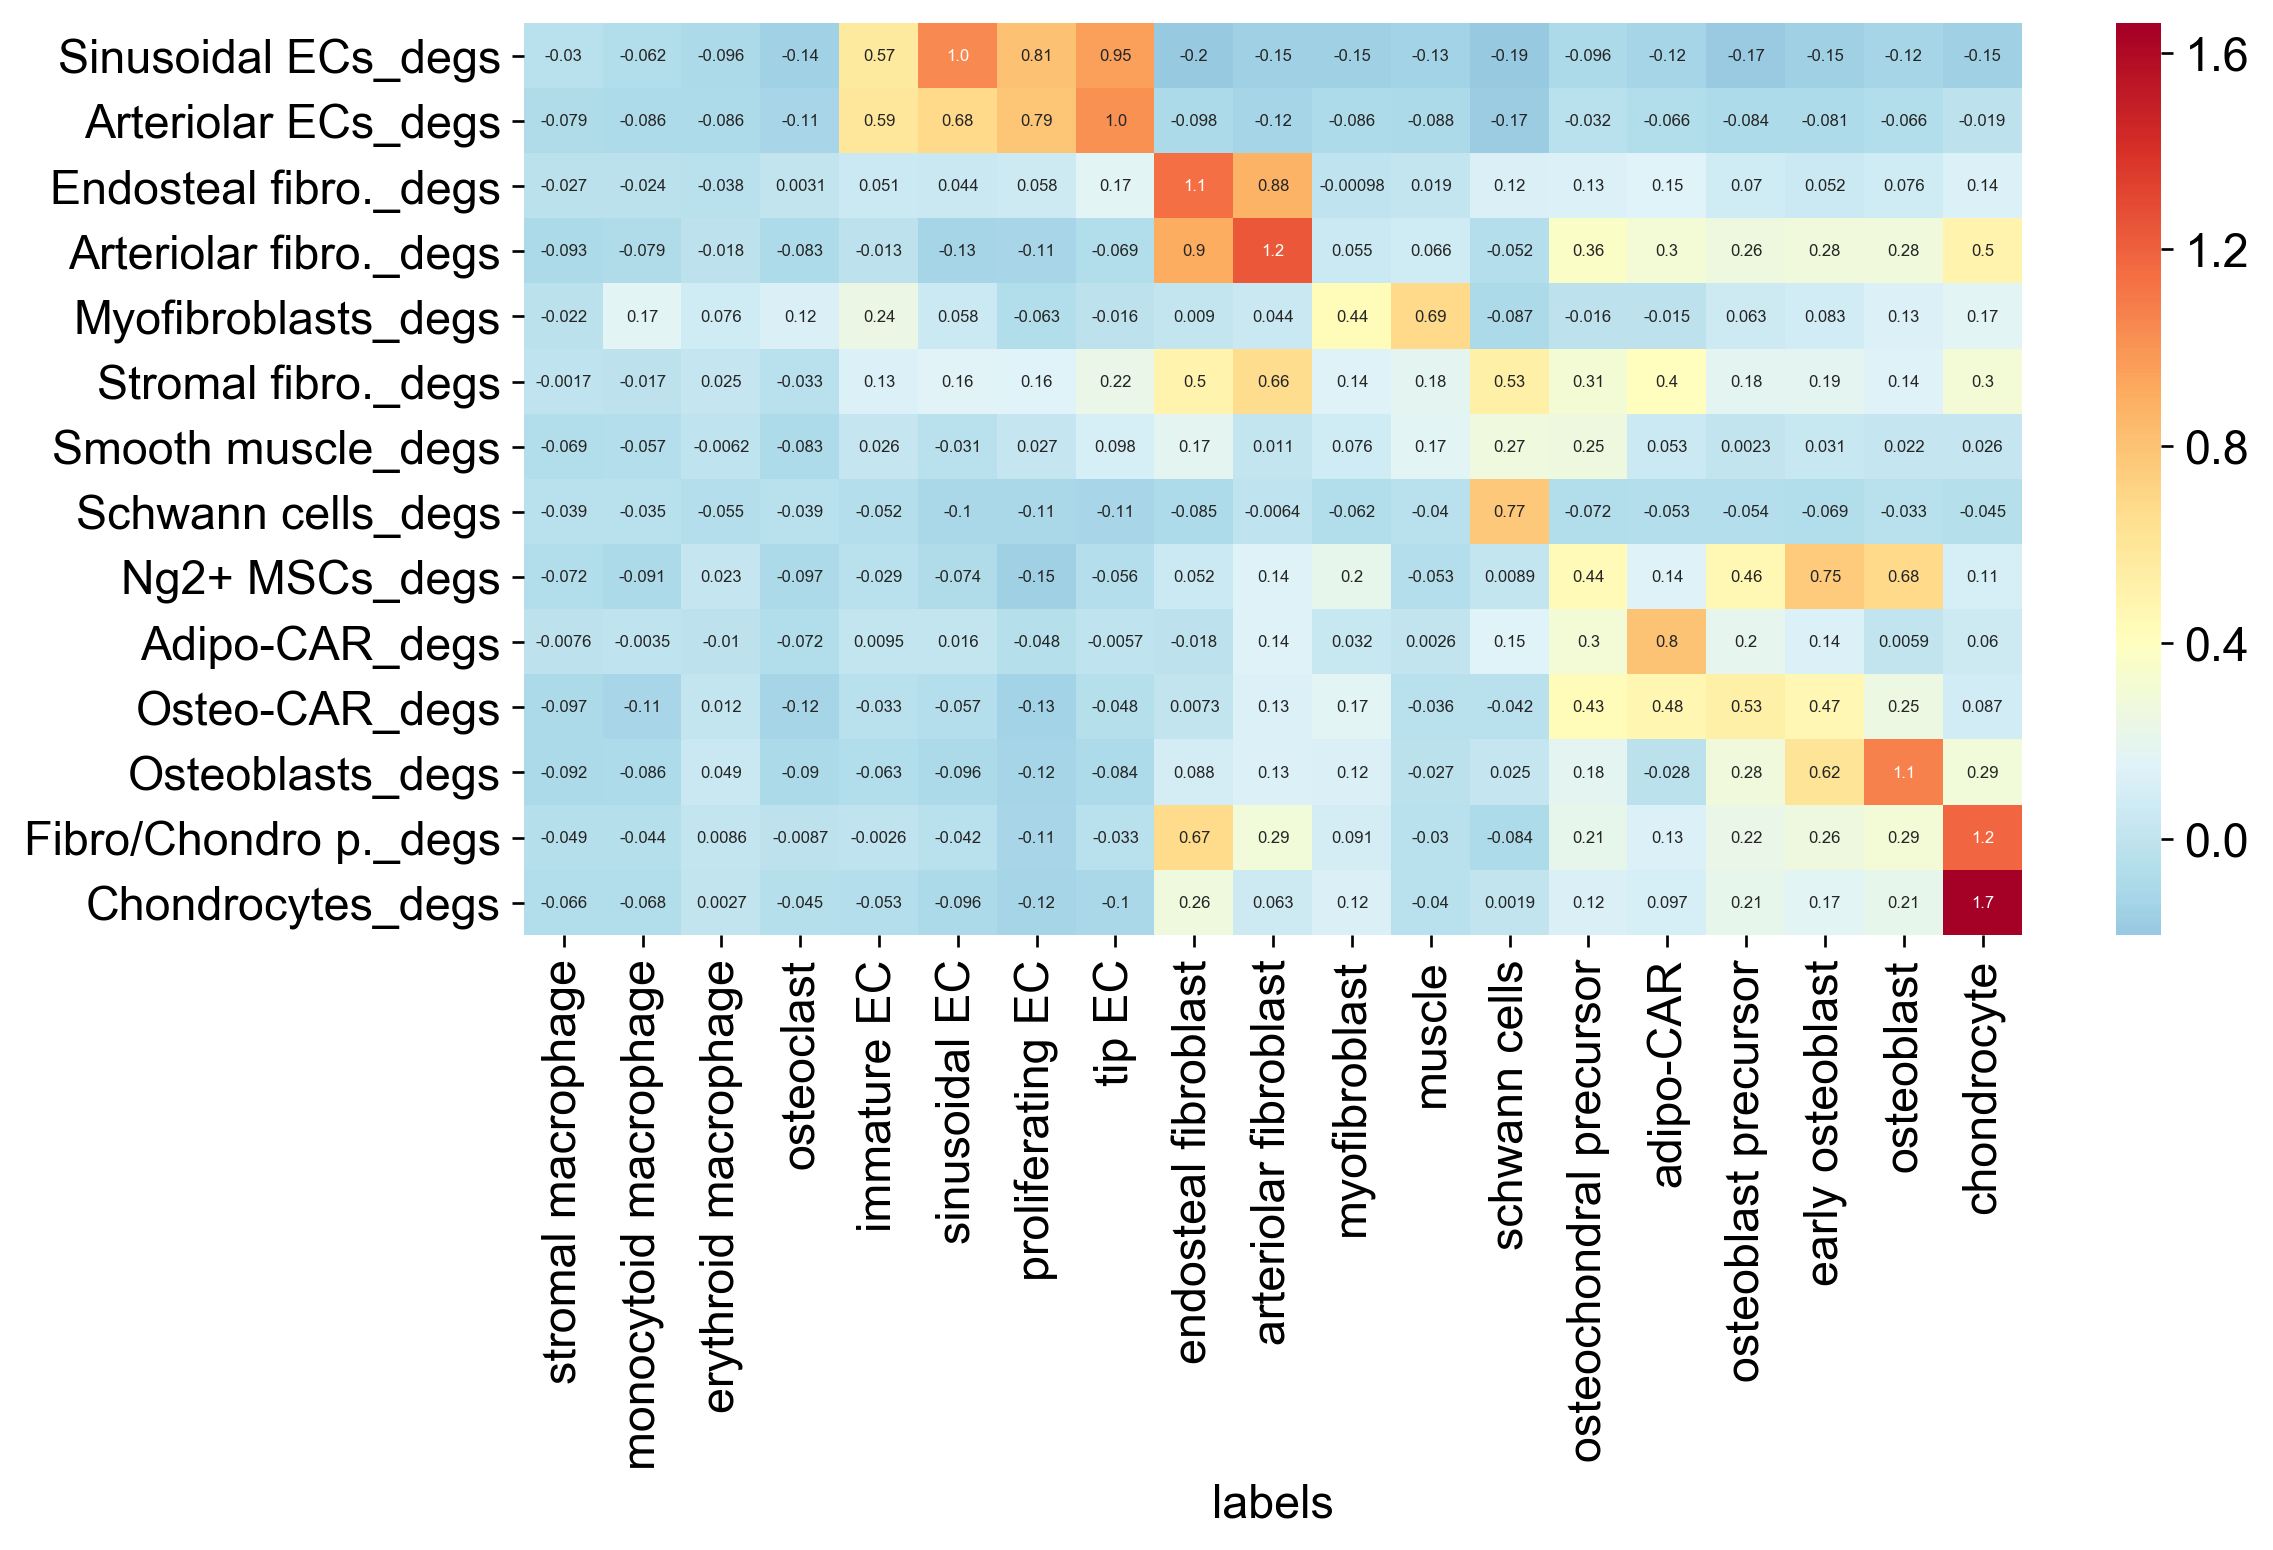

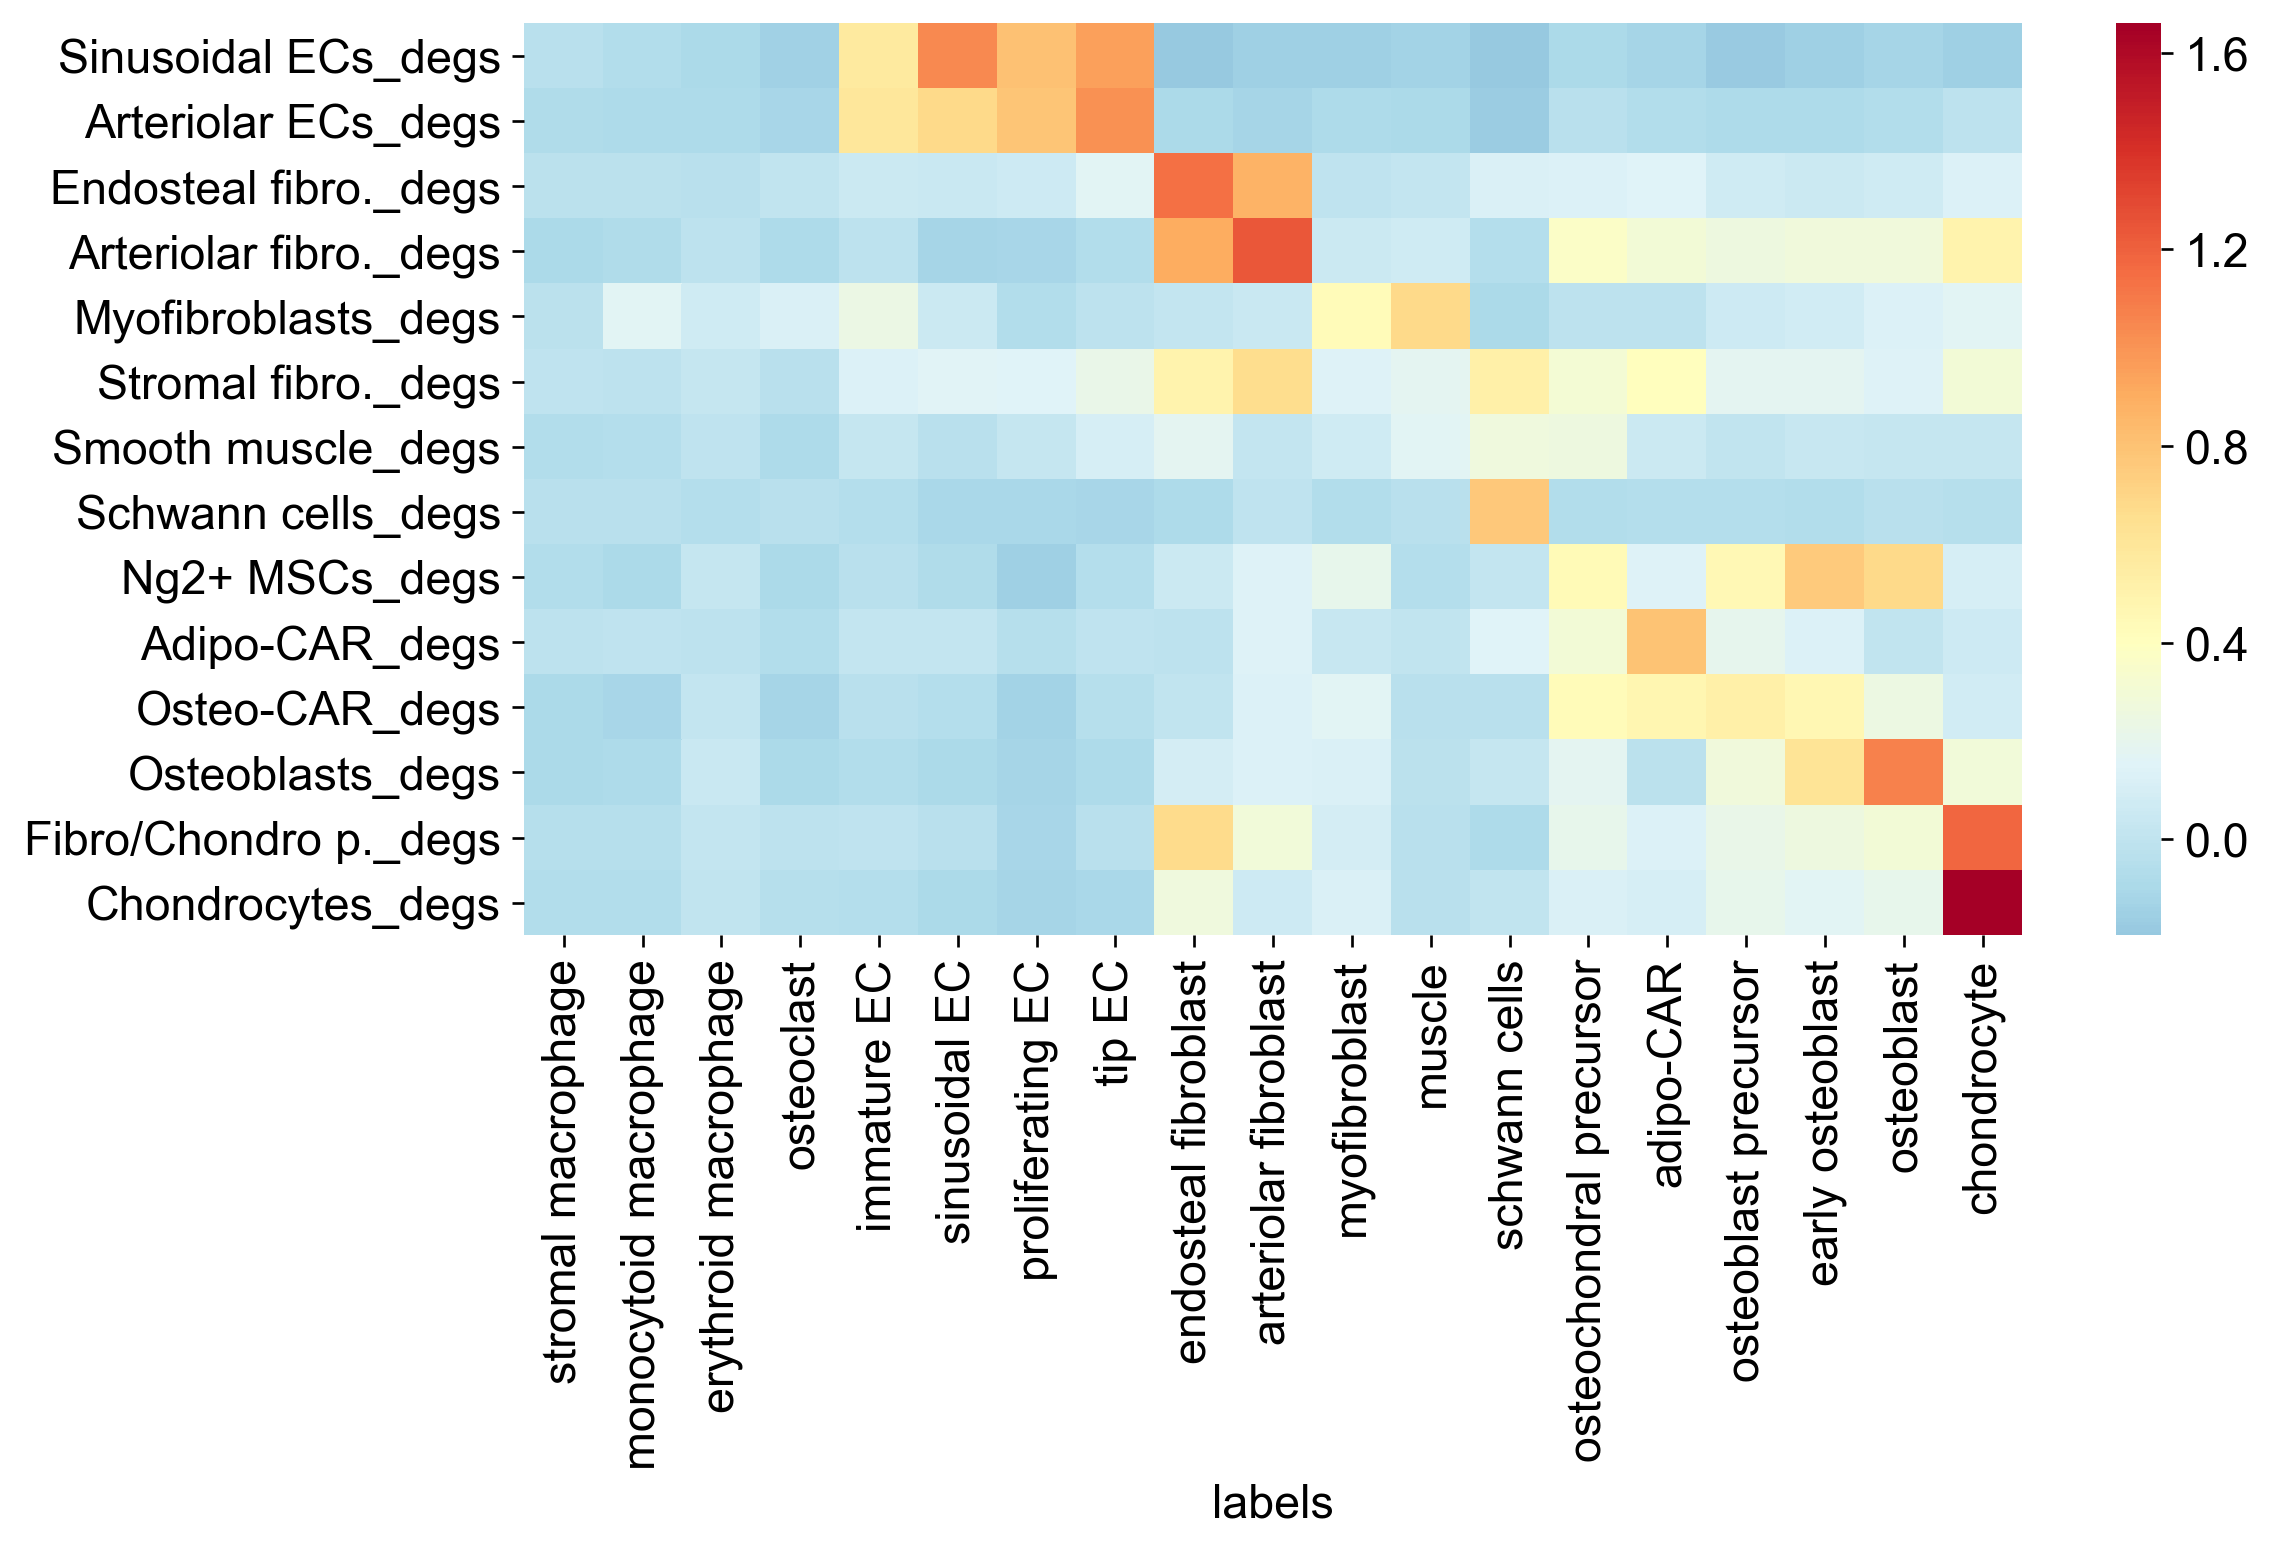

In [45]:
plt.figure(figsize=(10, 5))
fig = sns.heatmap(mean_enrichment_scores_df, annot=True, fmt=".2", center=0.4, annot_kws={"size": 5}, cmap="RdYlBu_r").get_figure()
fig.savefig("figures/figs6d_mouse_stroma_comparison_numbers_yes_20210126.pdf")
# plot gene scores as a heatmap. 
plt.figure(figsize=(10, 5))
fig = sns.heatmap(mean_enrichment_scores_df, cmap="RdYlBu_r", center=0.4).get_figure() 
fig.savefig("figures/figs6d_mouse_stroma_comparison_numbers_no_20210126.pdf")

# Save data

In [46]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [47]:
adata.X

<6379x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 15838577 stored elements in Compressed Sparse Row format>

In [48]:
adata.raw.X

<6379x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 17745868 stored elements in Compressed Sparse Row format>

In [49]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/figs6b_mouse_enrichment_comparison_20210126.h5ad")